In [1]:

# 1) Setup & Imports
import os
import re
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline

import joblib

# NLP utilities
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# gensim for Word2Vec
import gensim
from gensim.models import Word2Vec

# TensorFlow/Keras for BiLSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# HuggingFace for transformer fine-tune
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          DataCollatorWithPadding)
from datasets import Dataset

# Optional: xgboost
import xgboost as xgb

# Make plots pretty
sns.set(style="whitegrid")

# Download NLTK assets
nltk.download('punkt')
nltk.download('stopwords')


c:\Users\NagendraB\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

# 2) Load data & quick inspection
# Replace path with your file path
DATA_PATH = 'FakeNewsNet.csv'  # <- change to actual path if needed
assert os.path.exists(DATA_PATH), f"Data file not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print('\nLoaded dataframe shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nSample rows:')
print(df.head())

# Quick clean: ensure 'real' exists and is integer
if 'real' not in df.columns:
    raise ValueError("Expected column 'real' not found in CSV")

df = df[['title','news_url','source_domain','tweet_num','real']].copy()
# Combine title and url or title and text if available; here only title exists
# If your file has a 'text' column use that instead of title

df['text'] = df['title'].fillna('')

df['real'] = df['real'].astype(int)



Loaded dataframe shape: (23196, 5)

Columns: ['title', 'news_url', 'source_domain', 'tweet_num', 'real']

Sample rows:
                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                            news_url        source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...           toofab.com   
1  https://www.today.com/style/see-people-s-choic...        www.today.com   
2  https://www.etonline.com/news/220806_sophia_bu...     www.etonline.com   
3  https://www.dailymail.co.uk/news/article-33655...  www.dailymail.co.uk   
4  https://www.zerchoo.com/entertainment/gossip-g...      www.zerchoo.com   

   tweet_num  real  
0         42     1  
1          0     1  
2         63     


Class distribution:
real
1    17441
0     5755
Name: count, dtype: int64


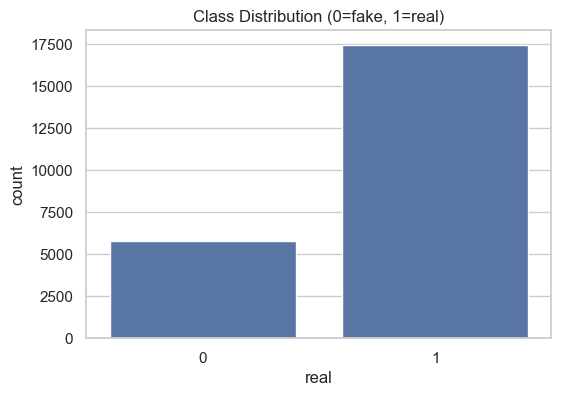

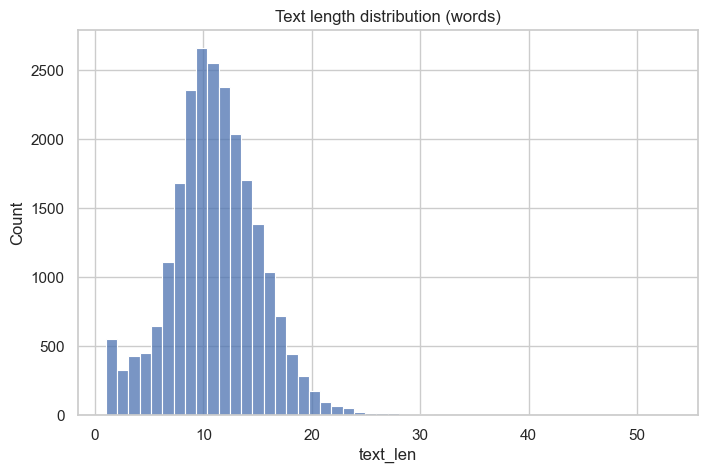

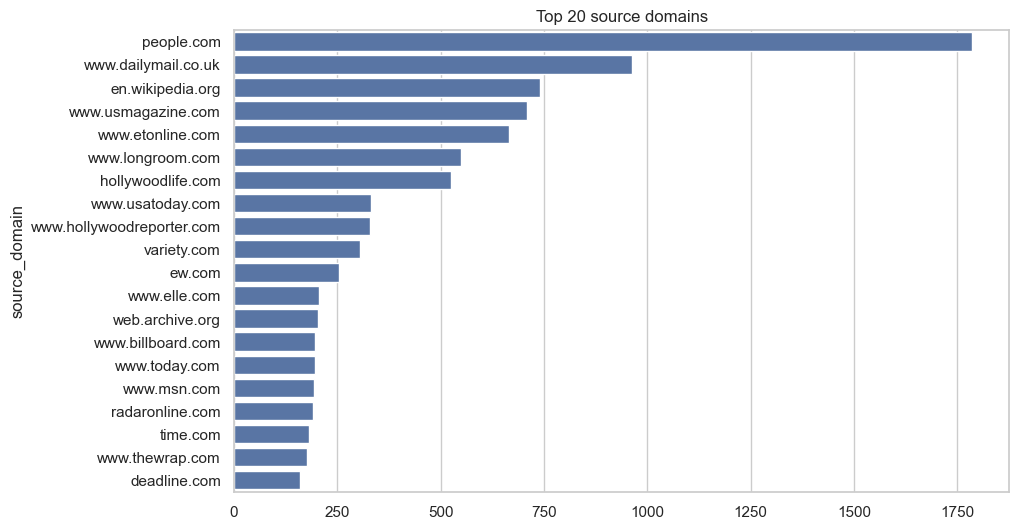

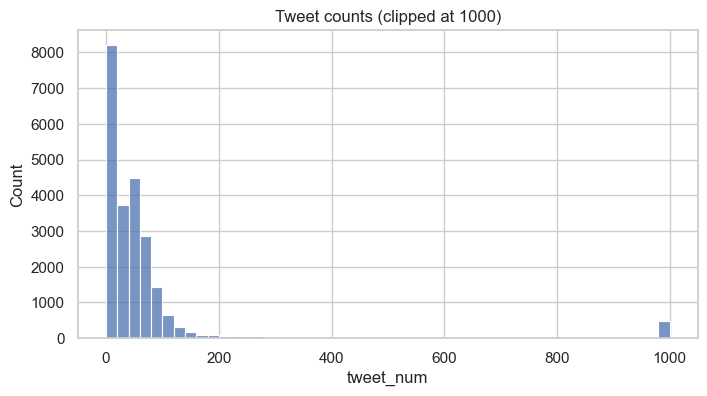

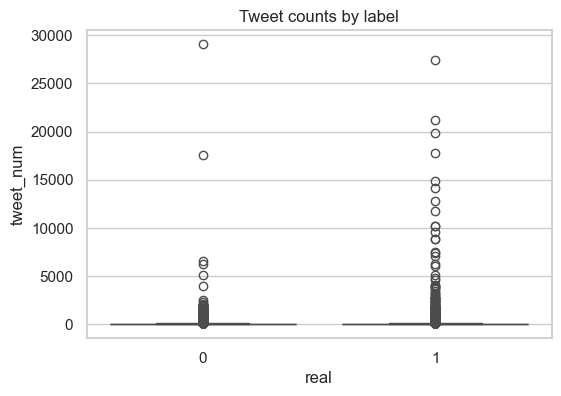

In [3]:

# 3) EDA
print('\nClass distribution:')
print(df['real'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='real', data=df)
plt.title('Class Distribution (0=fake, 1=real)')
plt.show()

# Text length distribution
df['text_len'] = df['text'].str.split().map(len)
plt.figure(figsize=(8,5))
sns.histplot(df['text_len'], bins=50)
plt.title('Text length distribution (words)')
plt.show()

# Top source domains
top_domains = df['source_domain'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(y=top_domains.index, x=top_domains.values)
plt.title('Top 20 source domains')
plt.show()

# Tweet counts distribution (tweet_num)
plt.figure(figsize=(8,4))
sns.histplot(df['tweet_num'].clip(upper=1000), bins=50)
plt.title('Tweet counts (clipped at 1000)')
plt.show()

# Correlation between tweet_num and label
plt.figure(figsize=(6,4))
sns.boxplot(x='real', y='tweet_num', data=df)
plt.title('Tweet counts by label')
plt.show()


In [4]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:

# 4) Preprocessing
STOPWORDS = set(stopwords.words('english'))

import string
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lem = WordNetLemmatizer()

url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
html_pattern = re.compile(r'<.*?>')
non_alphanum = re.compile(r'[^a-zA-Z0-9\s]')


def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = url_pattern.sub('', text)
    text = html_pattern.sub('', text)
    text = text.lower()
    text = non_alphanum.sub(' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [lem.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Apply cleaning (this may take a bit of time)
print('\nCleaning text...')
df['clean_text'] = df['text'].map(clean_text)
print('Done. Sample:')
print(df[['text','clean_text']].head(5))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Cleaning text...
Done. Sample:
                                                text  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                          clean_text  
0  kandi burruss explodes rape accusation real ho...  
1      people choice award 2018 best red carpet look  
2  sophia bush sends sweet birthday message one t...  
3  colombian singer maluma spark rumour inappropr...  
4  gossip girl 10 year later upper east siders sh...  


In [6]:

# 5) Feature creation and train/test split
X = df['clean_text']
y = df['real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('\nTrain/Test sizes:', X_train.shape, X_test.shape)

# TF-IDF vectorizer (fit on training)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print('TF-IDF shape:', X_train_tfidf.shape)



Train/Test sizes: (18556,) (4640,)
TF-IDF shape: (18556, 30000)


In [7]:

# 6) Model 1: TF-IDF + Logistic Regression (with simple hyperparam search)
print('\nTraining Logistic Regression (TF-IDF)...')
log_clf = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.01, 0.1, 1, 10]}
clf_grid = GridSearchCV(log_clf, param_grid, cv=3, scoring='f1', n_jobs=-1)
clf_grid.fit(X_train_tfidf, y_train)
print('Best params:', clf_grid.best_params_)

best_log = clf_grid.best_estimator_

# Evaluate
y_pred_log = best_log.predict(X_test_tfidf)
print('\nLogistic Regression Classification report:')
print(classification_report(y_test, y_pred_log))

# Save TF-IDF and model
os.makedirs('models', exist_ok=True)
joblib.dump(tfidf, 'models/tfidf_vectorizer.joblib')
joblib.dump(best_log, 'models/logistic_tfidf.joblib')



Training Logistic Regression (TF-IDF)...
Best params: {'C': 10}

Logistic Regression Classification report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.66      1151
           1       0.88      0.92      0.90      3489

    accuracy                           0.84      4640
   macro avg       0.80      0.77      0.78      4640
weighted avg       0.84      0.84      0.84      4640



['models/logistic_tfidf.joblib']

In [8]:

# 7) Model 2: TF-IDF + SVM
print('\nTraining SVM (TF-IDF)...')
svm = SVC(kernel='linear', probability=True)
param_grid = {'C': [0.1, 1, 10]}
svm_grid = GridSearchCV(svm, param_grid, cv=3, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)
print('Best params SVM:', svm_grid.best_params_)
best_svm = svm_grid.best_estimator_

# Evaluate
y_pred_svm = best_svm.predict(X_test_tfidf)
print('\nSVM Classification report:')
print(classification_report(y_test, y_pred_svm))
joblib.dump(best_svm, 'models/svm_tfidf.joblib')



Training SVM (TF-IDF)...
Best params SVM: {'C': 1}

SVM Classification report:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1151
           1       0.88      0.94      0.91      3489

    accuracy                           0.85      4640
   macro avg       0.82      0.77      0.79      4640
weighted avg       0.85      0.85      0.85      4640



['models/svm_tfidf.joblib']

In [9]:

# 8) Model 3: TF-IDF + XGBoost (sklearn wrapper)
print('\nTraining XGBoost (TF-IDF)...')
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
param_grid = {'n_estimators':[100,200], 'max_depth':[3,6], 'learning_rate':[0.01,0.1]}
xgb_grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train_tfidf, y_train)
print('Best params XGB:', xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_

# Evaluate
y_pred_xgb = best_xgb.predict(X_test_tfidf)
print('\nXGBoost Classification report:')
print(classification_report(y_test, y_pred_xgb))
joblib.dump(best_xgb, 'models/xgb_tfidf.joblib')



Training XGBoost (TF-IDF)...


c:\Users\NagendraB\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:03:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params XGB: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

XGBoost Classification report:
              precision    recall  f1-score   support

           0       0.79      0.43      0.56      1151
           1       0.84      0.96      0.89      3489

    accuracy                           0.83      4640
   macro avg       0.81      0.70      0.72      4640
weighted avg       0.82      0.83      0.81      4640



['models/xgb_tfidf.joblib']

In [10]:

# 9) Model 4: Word2Vec + BiLSTM
# Prepare tokenizer and sequences
print('\nPreparing Word2Vec + BiLSTM...')
all_texts = X_train.tolist() + X_test.tolist()

# Tokenizer for Keras
keras_tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(all_texts)

X_train_seq = keras_tokenizer.texts_to_sequences(X_train)
X_test_seq = keras_tokenizer.texts_to_sequences(X_test)

MAX_LEN = 128
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Create embedding matrix using Word2Vec trained on our corpus
sentences = [t.split() for t in all_texts]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)

# Build embedding matrix
word_index = keras_tokenizer.word_index
num_words = min(30000, len(word_index)+1)
EMB_DIM = 100
embedding_matrix = np.zeros((num_words, EMB_DIM))
for word, i in word_index.items():
    if i>=num_words:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Define model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=EMB_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train (use validation split)
BATCH = 64
EPOCHS = 6
history = model.fit(X_train_pad, y_train.values, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH)

# Evaluate
y_pred_prob = model.predict(X_test_pad).ravel()
y_pred_lstm = (y_pred_prob>0.5).astype(int)
print('\nBiLSTM Classification report:')
print(classification_report(y_test, y_pred_lstm))

# Save Keras model and tokenizer + word2vec
model.save('models/bilstm_w2v.h5')
joblib.dump(keras_tokenizer, 'models/keras_tokenizer.joblib')
w2v_model.save('models/w2v_model.model')



Preparing Word2Vec + BiLSTM...


c:\Users\NagendraB\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,568,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,568,000 (5.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,568,000 (5.98 MB)

Epoch 1/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.7947 - loss: 0.4711 - val_accuracy: 0.8082 - val_loss: 0.4356
Epoch 2/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.8071 - loss: 0.4432 - val_accuracy: 0.8130 - val_loss: 0.4258
Epoch 3/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 49s 186ms/step - accuracy: 0.8120 - loss: 0.4344 - val_accuracy: 0.8120 - val_loss: 0.4265
Epoch 4/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - accuracy: 0.8166 - loss: 0.4268 - val_accuracy: 0.8152 - val_loss: 0.4244
Epoch 5/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.8177 - loss: 0.4219 - val_accuracy: 0.8184 - val_loss: 0.4135
Epoch 6/6
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8195 - loss: 0.4173 - val_accuracy: 0.8141 - val_loss: 0.4126
145/145 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step



BiLSTM Classification report:
              precision    recall  f1-score   support

           0       0.75      0.44      0.56      1151
           1       0.84      0.95      0.89      3489

    accuracy                           0.83      4640
   macro avg       0.79      0.70      0.72      4640
weighted avg       0.82      0.83      0.81      4640



In [11]:
# 10) Model 5: Transformer fine-tune (FAST DistilBERT) - HuggingFace Trainer
import torch
import pandas as pd
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("\nPreparing dataset for FAST transformer fine-tuning...")

# Convert to datasets
train_df = pd.DataFrame({'text': X_train.tolist(), 'label': y_train.values})
valid_df = pd.DataFrame({'text': X_test.tolist(), 'label': y_test.values})

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Faster tokenization: shorter max_length
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128        # 🚀 major speed boost
    )

# Create HuggingFace datasets
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)

# OPTIONAL: small dataset for speed (uncomment to activate)
# train_dataset = train_dataset.shuffle(seed=42).select(range(3000))
# valid_dataset = valid_dataset.select(range(1000))

train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
valid_dataset  = valid_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Load model
model_trans = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# FAST training settings
training_args = TrainingArguments(
    output_dir="models/transformer",
    eval_strategy="epoch",
    save_strategy="no",               # 🚀 no slow checkpointing
    learning_rate=2e-5,
    per_device_train_batch_size=8,    # slightly smaller batch
    per_device_eval_batch_size=16,
    num_train_epochs=1,               # 🚀 only 1 epoch (can increase later)
    weight_decay=0.01,
    logging_dir="models/transformer/logs",
    logging_steps=100,
    fp16=True,                        # 🚀 huge speed-up on GPU
    optim="adafactor",                # 🚀 much faster than AdamW
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Trainer
trainer = Trainer(
    model=model_trans,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\n🚀 Starting FAST transformer fine-tuning...")
trainer.train()

# Save final model
trainer.save_model("models/transformer/distilbert_finetuned_fast")
tokenizer.save_pretrained("models/transformer/distilbert_finetuned_fast")

# Evaluate
preds_output = trainer.predict(valid_dataset)
print("\nTransformer evaluation metrics:", preds_output.metrics)



Preparing dataset for FAST transformer fine-tuning...


Map: 100%|██████████| 4640/4640 [00:00<00:00, 17794.56 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\NagendraB\AppData\Local\Temp\ipykernel_6808\767576575.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Starting FAST transformer fine-tuning...


c:\Users\NagendraB\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.386700,0.371639,0.849569,0.875034,0.933219,0.903190


c:\Users\NagendraB\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Transformer evaluation metrics: {'test_loss': 0.3716391623020172, 'test_accuracy': 0.8495689655172414, 'test_precision': 0.875033593120129, 'test_recall': 0.9332186873029521, 'test_f1': 0.9031900138696255, 'test_runtime': 582.884, 'test_samples_per_second': 7.96, 'test_steps_per_second': 0.498}


In [12]:

# 11) Compare models - compute key metrics on test set
print('\nComparing models on test set...')

def eval_and_report(model, X_test_vec, name, is_prob=False):
    if is_prob:
        probs = model.predict_proba(X_test_vec)[:,1]
        preds = (probs>0.5).astype(int)
    else:
        preds = model.predict(X_test_vec)
    print(f'--- {name} ---')
    print(classification_report(y_test, preds))
    try:
        auc = roc_auc_score(y_test, model.predict_proba(X_test_vec)[:,1])
        print('ROC AUC:', auc)
    except Exception:
        pass

# Evaluate sklearn models
eval_and_report(best_log, X_test_tfidf, 'Logistic Regression', is_prob=True)
eval_and_report(best_svm, X_test_tfidf, 'SVM', is_prob=False)
eval_and_report(best_xgb, X_test_tfidf, 'XGBoost', is_prob=True)

# Evaluate BiLSTM
print('--- BiLSTM ---')
print(classification_report(y_test, y_pred_lstm))

# Transformer evaluation already printed by trainer



Comparing models on test set...
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.72      0.62      0.66      1151
           1       0.88      0.92      0.90      3489

    accuracy                           0.84      4640
   macro avg       0.80      0.77      0.78      4640
weighted avg       0.84      0.84      0.84      4640

ROC AUC: 0.8721038119307074
--- SVM ---
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1151
           1       0.88      0.94      0.91      3489

    accuracy                           0.85      4640
   macro avg       0.82      0.77      0.79      4640
weighted avg       0.85      0.85      0.85      4640

ROC AUC: 0.8697645747252317
--- XGBoost ---
              precision    recall  f1-score   support

           0       0.79      0.43      0.56      1151
           1       0.84      0.96      0.89      3489

    accuracy                         

In [13]:

# 12) Pick best model (by F1 on validation/test) - example logic
# Collect F1 scores for each model
from sklearn.metrics import f1_score
scores = {}

scores['logistic'] = f1_score(y_test, best_log.predict(X_test_tfidf))
scores['svm'] = f1_score(y_test, best_svm.predict(X_test_tfidf))
scores['xgb'] = f1_score(y_test, best_xgb.predict(X_test_tfidf))
scores['bilstm'] = f1_score(y_test, y_pred_lstm)

# For transformer, use preds
transformer_preds = np.argmax(preds_output.predictions, axis=1)
scores['transformer'] = f1_score(y_test, transformer_preds)

print('\nF1 scores:')
print(scores)

best_model_name = max(scores, key=lambda k: scores[k])
print('\nBest model by F1:', best_model_name, 'with F1 =', scores[best_model_name])



F1 scores:
{'logistic': 0.8989078689442733, 'svm': 0.9067293077241951, 'xgb': 0.8945473936808426, 'bilstm': 0.8912751677852349, 'transformer': 0.9031900138696255}

Best model by F1: svm with F1 = 0.9067293077241951


In [14]:

# 13) How to load & use saved models (examples)
print('\nExample: load logistic model and predict new text')
loaded_tfidf = joblib.load('models/tfidf_vectorizer.joblib')
loaded_log = joblib.load('models/logistic_tfidf.joblib')

def predict_text_sk(text, model, vectorizer):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    prob = model.predict_proba(vec)[:,1][0]
    pred = int(prob>0.5)
    return pred, prob

example = "President signs new healthcare bill after long debate"
print('Example prediction (Logistic):', predict_text_sk(example, loaded_log, loaded_tfidf))

# Example: load transformer model for inference (using tokenizer)
from transformers import AutoModelForSequenceClassification, AutoTokenizer
trans_path = 'models/transformer/distilbert_finetuned'
if os.path.exists(trans_path):
    tok = AutoTokenizer.from_pretrained(trans_path)
    mod = AutoModelForSequenceClassification.from_pretrained(trans_path)
    # simple pipeline inference
    inputs = tok(example, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        logits = mod(**inputs).logits
    pred = int(torch.argmax(logits, dim=-1).item())
    print('Transformer pred (0 fake /1 real):', pred)

print('\nPipeline completed. Models and artifacts saved under ./models')

# End of script



Example: load logistic model and predict new text
Example prediction (Logistic): (1, np.float64(0.9370427051641615))

Pipeline completed. Models and artifacts saved under ./models
